### Instal Ollama :

curl -fsSL https://ollama.com/install.sh | sh

In [ ]:
# ANSI escape codes
RED = "\033[91m"
GREEN = "\033[92m"
YELLOW = "\033[93m"
BLUE = "\033[94m"
RESET = "\033[0m"

print(f"{RED}This is red text{RESET}")
print(f"{GREEN}This is green text{RESET}")
print(f"{YELLOW}This is yellow text{RESET}")
print(f"{BLUE}This is blue text{RESET}")


## Part1 : Graph with a single Node 

In [ ]:
import os

In [ ]:
#os.environ["LANGCHAIN_TRACING_V2"] = "true"
#os.environ["LANGCHAIN_PROJECT"] = "LangGraph Tutorial"

In [ ]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

In [ ]:
from langchain_community.llms import Ollama

llm = Ollama(model="qwen2:1.5b")

In [ ]:
def chatbot(state):
    prompt = state["messages"]
    response = llm.invoke(prompt)
    return {"messages": [response]}

- each time the node is executed the function is called.

In [ ]:
graph_builder.add_node("chatbot", chatbot)

In [ ]:
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot",END)

In [ ]:
Our_Graph = graph_builder.compile()

In [ ]:
from IPython.display import Image, display

try:
    display(Image(Our_Graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [ ]:
while True:
    user_input = input("User: ")
    if user_input.lower() in ["q"]:
        print("Goodbye!")
        break
    for event in Our_Graph.stream({"messages": ("user", user_input)}):
        for value in event.values():
            print("Assistant:", value["messages"][-1])

## Part2 : Graph with 2 nodes (LLM + Search Tool)

### Initialize the Graph and the State :

In [1]:
from typing import Annotated
from typing_extensions import TypedDict
from langchain_core.messages import BaseMessage, HumanMessage,ToolMessage,AIMessage
from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list, add_messages]

# Create the Object that we will use to bulid our graph
graph_builder = StateGraph(State)

### Tavily node:

- Tavily is the first research engine optimized for AI agents and LLMs.
- Main key features of this API is :
   - The results are page summaries our chat bot can use to answer questions not the just a dummy Scraping (Amazing !!).
   - The API choose the best results from search.

[Get Your Tavily API Key](https://app.tavily.com/home)

In [ ]:
import getpass
import os

os.environ["TAVILY_API_KEY"] = getpass.getpass()
#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

In [ ]:
from langchain_community.tools.tavily_search import TavilySearchResults

Tavily = TavilySearchResults(max_results=2)
tools = [Tavily]
#tool.invoke("What's a 'node' in LangGraph?")

In [ ]:
import json
from langchain_core.messages import ToolMessage

In [ ]:
def Get_AIMessage(state:State):
    messages = state.get("messages", []) 
    # .get : Return the value associeted to the key "messages" if the key not exist it returns an empty list
    if messages:
        message = messages[-1]
        # message is the last in messages list.
    return message

In [ ]:
def Tavily_Function(state:State):
    message = Get_AIMessage(state)
        
    Tavily_call = message.tool_calls[0]
    # Execute the Tool called by the LLM
    tool_arguments = Tavily_call["args"]
    
    print(f"⚙️{YELLOW} Tavily is Executing{RESET}")
    
    Tavily_result = Tavily.invoke(tool_arguments)
    Tavily_Message =  ToolMessage(content=json.dumps(Tavily_result),name=Tavily_call["name"],tool_call_id=Tavily_call["id"])
    
    return {"messages": Tavily_Message}


In [ ]:
graph_builder.add_node("Tavily", Tavily_Function)

### LLM node:

- **bind_Tools** : allow us to pass the Tools Schemas (descriptions) with the prompt every Time we send a quetion to the LLM. So the LLM can request a tool(s) if he need it (them).
- When you just use bind_tools(tools), the model can choose whether to return one tool call, multiple tool calls, or no tool calls at all.

In [ ]:
from langchain_experimental.llms.ollama_functions import OllamaFunctions

llm = OllamaFunctions(model="phi3:3.8b",format= "json")
llm_with_tools = llm.bind_tools(tools)

In [ ]:
def chatbot_Function(state: State):
    print("State messages :",state["messages"])
    print(f"💡{GREEN}LLM is Thinking !{RESET}")
    
    prompt = state["messages"]
    response = llm_with_tools.invoke(prompt)
    return {"messages": response}

In [ ]:
graph_builder.add_node("LLM", chatbot_Function)

### Design the Graph :

In [ ]:
from typing import Literal


def Condition_Function(state: State):
    """
    Use in the conditional_edge to route to the ToolsNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    messages = state.get("messages", [])
    
    if isinstance(state, list):
        ai_message = state[-1]
        
    elif messages : # check that messages is not an empty list
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0: # Check if the LLM ask for a tool
        
        if Ask_for_Tavily(ai_message.tool_calls):
            return "Ask for Tavily"
    return "Ask for END"

def Ask_for_Tavily(tool_calls:list):
    for tool_call in tool_calls:
        if tool_call['name'] == "tavily_search_results_json":
            return True
    return False

In [ ]:
graph_builder.add_conditional_edges("LLM",Condition_Function,{"Ask for Tavily": "Tavily", "Ask for END": "__end__"},)
graph_builder.add_edge("Tavily", "LLM")
graph_builder.add_edge(START, "LLM")
graph = graph_builder.compile()

### Visualize the Graph

In [ ]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

### Interact With The Graph:

In [ ]:
from langchain_core.messages import AIMessage

My_Quetion = "What is a node in Langraph?"

for event in graph.stream({"messages": [("user", My_Quetion)]}):
    for value in event.values():
        print(value)

## Part3 :Graph with Multiple Nodes As I want :

### Graph initialization :

In [1]:
from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list, add_messages]

# Create the Object that we will use to bulid our graph
graph_builder = StateGraph(State)

### Tools Nodes :

#### Weather Tool node :
- We will a Weather API built in by langchain.
- I already Construct the tool in My_Tools.py

In [9]:
from My_Tools import OpenWeather

- Test the tool

In [10]:
print(OpenWeather.name)
print(OpenWeather.description)
print(OpenWeather.args)

OpenWeather
Give the Weather information for a specific Location
{'Location': {'title': 'Location', 'description': 'The Location is often a city name like London, Casablanca ...', 'type': 'string'}}


In [11]:
print(OpenWeather.invoke({"Location": "Meknes"})) # invoke execute the run()

In Meknes, the current weather is as follows:
Detailed status: broken clouds
Wind speed: 4.12 m/s, direction: 330°
Humidity: 44%
Temperature: 
  - Current: 37.49°C
  - High: 37.49°C
  - Low: 37.49°C
  - Feels like: 44.08°C
Rain: {}
Heat index: None
Cloud cover: 75%


- Create the Node Function:

In [12]:
from langchain_core.messages import ToolMessage

In [13]:
def Get_AIMessage(state:State):
    messages = state.get("messages", []) 
    # .get : Return the value associeted to the key "messages" if the key not exist it returns an empty list
    if messages:
        message = messages[-1]
        # message is the last in messages list.
    return message

def OpenWeather_Function(state:State,tool = OpenWeather):
    message = Get_AIMessage(state)
        
    Tool_call = message.tool_calls[0]
    # Execute the Tool called by the LLM
    Tool_arguments = Tool_call["args"]
    Tool_Name = Tool_call["name"]
    print(f"⚙️{YELLOW} {Tool_Name} is Executing{RESET}")
    
    Tool_result = tool.invoke(Tool_arguments)
    Tool_Message =  ToolMessage(content=Tool_result,name=Tool_call["name"],tool_call_id=Tool_call["id"])
    
    return {"messages": Tool_Message}


In [14]:
graph_builder.add_node("OpenWeather", OpenWeather_Function)

#### Tavily Tool Node :

In [15]:
from My_Tools import Tavily
from langchain_core.messages import ToolMessage

In [16]:
print(Tavily.name)
print(Tavily.description)
print(Tavily.args)

Tavily
A search engine optimized for comprehensive, accurate, and trusted results. Useful for when you need to answer questions about current events. Input should be a search query.
{'query': {'title': 'Query', 'description': 'search query to look up', 'type': 'string'}}


In [17]:
def Get_AIMessage(state:State):
    messages = state.get("messages", []) 
    # .get : Return the value associeted to the key "messages" if the key not exist it returns an empty list
    if messages:
        message = messages[-1]
        # message is the last in messages list.
    return message

def Tavily_Function(state:State,tool = Tavily):
    message = Get_AIMessage(state)
        
    Tool_call = message.tool_calls[0]
    # Execute the Tool called by the LLM
    Tool_arguments = Tool_call["args"]
    Tool_Name = Tool_call["name"]
    print(f"⚙️{YELLOW} {Tool_Name} is Executing{RESET}")
    
    Tool_result = tool.invoke(Tool_arguments)
    Tool_Message =  ToolMessage(content=Tool_result,name=Tool_call["name"],tool_call_id=Tool_call["id"])
    
    return {"messages": Tool_Message}


In [18]:
graph_builder.add_node("Tavily", Tavily_Function)

### LLM node :

In [19]:
tools = [OpenWeather,Tavily]

In [20]:
from langchain_experimental.llms.ollama_functions import OllamaFunctions

llm = OllamaFunctions(model="gemma2:9b",format= "json")
llm_with_tools = llm.bind_tools(tools)

In [21]:
def LLM_function(state:State):
    print(f"{BLUE}State messages :{RESET}",state["messages"])
    print(f"💡{GREEN}LLM is Thinking !{RESET}")
    
    prompt = state["messages"]
    response = llm_with_tools.invoke(prompt)
    return {"messages": response}

In [22]:
graph_builder.add_node("LLM", LLM_function)

### Desing the Graph:

In [23]:
def Condition_Function(state: State):
    messages = state.get("messages", [])
    
    if isinstance(state, list):
        ai_message = state[-1]
        
    elif messages : # check that messages is not an empty list
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in State: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0: # Check if the LLM ask for a tool
        
        for tool_call in ai_message.tool_calls:
            if tool_call['name'] == "OpenWeather":
                return "OpenWeather"
            if tool_call['name'] == "Tavily":
                return "Tavily"
    return "__end__"


In [24]:
graph_builder.add_conditional_edges("LLM",Condition_Function)
graph_builder.add_edge("OpenWeather", "LLM") # if the OpenWeather is invoked so the next node will be the LLM
graph_builder.add_edge("Tavily", "LLM")
graph_builder.add_edge(START, "LLM")
graph = graph_builder.compile()

### Visualize the Graph

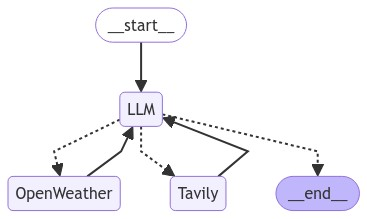

In [25]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

### Interact With The Graph:

In [ ]:
My_Quetion = "What is a dog ?"
Input_Message = {"messages": [("human", My_Quetion)]}

async for chunk in graph.astream(Input_Message, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

## Part 4 : Add Memory to our Agent:

In [ ]:
from langgraph.checkpoint.sqlite import SqliteSaver

memory = SqliteSaver.from_conn_string(":memory:")

In [ ]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

In [ ]:
from langchain_community.llms import Ollama

llm = Ollama(model="gemma2:9b")

In [ ]:
def LLM_function(state:State):
    print(f"{BLUE}State messages :{RESET}",state["messages"])
    print(f"💡{GREEN}LLM is Thinking !{RESET}")
    
    prompt = state["messages"]
    response = llm.invoke(prompt)
    return {"messages": response}

In [ ]:
graph_builder.add_node("LLM", LLM_function)
graph_builder.add_edge(START, "LLM")
graph_builder.add_edge("LLM",END)

In [ ]:
graph = graph_builder.compile(checkpointer=memory)

In [ ]:
config = {"configurable": {"thread_id": "1"}} 
# We configurate here the id of the State to load by the graph

My_Quetion = "Hi Do you know About Morroco?"
Input_Message = {"messages": [("user", My_Quetion)]}

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(Input_Message, config, stream_mode="values")
for event in events:
    event["messages"][-1].pretty_print()

In [ ]:
config = {"configurable": {"thread_id": "1"}} 
# We configurate here the id of the State to load by the graph

My_Quetion = "What is the Capital?"
Input_Message = {"messages": [("user", My_Quetion)]}
# The config is the **second positional argument** to stream() or invoke()!

events = graph.stream(Input_Message, config, stream_mode="values")
for event in events:
    event["messages"][-1].pretty_print()

In [ ]:
State_tread1 =graph.get_state(config)
print(State_tread1)

## Part 5 : Human in the Loop:

In [ ]:
from langgraph.checkpoint.sqlite import SqliteSaver

memory = SqliteSaver.from_conn_string(":memory:")

In [ ]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

#### AskNews Tool Node :

In [ ]:
from My_Tools import AskNews
from langchain_core.messages import ToolMessage

In [ ]:
print(AskNews.name) 
# This is importatnt because This is the Name that the LLM will use to call the Tool 
print(AskNews.description)
print(AskNews.args)

In [ ]:
def Get_AIMessage(state:State):
    messages = state.get("messages", []) 
    # .get : Return the value associeted to the key "messages" if the key not exist it returns an empty list
    if messages:
        message = messages[-1]
        # message is the last in messages list.
    return message

def AskNews_Function(state:State,tool = AskNews):
    message = Get_AIMessage(state)
        
    Tool_call = message.tool_calls[0]
    # Execute the Tool called by the LLM
    Tool_arguments = Tool_call["args"]
    Tool_Name = Tool_call["name"]
    print(f"⚙️{YELLOW} {Tool_Name} is Executing{RESET}")
    
    Tool_result = tool.invoke(Tool_arguments)
    Tool_Message =  ToolMessage(content=Tool_result,name=Tool_call["name"],tool_call_id=Tool_call["id"])
    
    return {"messages": Tool_Message}


In [ ]:
graph_builder.add_node("AskNews", AskNews_Function)

### LLM node :

In [ ]:
tools = [AskNews]

In [ ]:
from langchain_experimental.llms.ollama_functions import OllamaFunctions

llm = OllamaFunctions(model="gemma2:9b",format= "json")
llm_with_tools = llm.bind_tools(tools)

In [ ]:
def LLM_function(state:State):
    print(f"{BLUE}State messages :{RESET}",state["messages"])
    print(f"💡{GREEN}LLM is Thinking !{RESET}")
    
    prompt = state["messages"]
    response = llm_with_tools.invoke(prompt)
    return {"messages": response}

In [ ]:
graph_builder.add_node("LLM", LLM_function)

### Desing the Graph:

In [ ]:
def Condition_Function(state: State):
    messages = state.get("messages", [])
    
    if isinstance(state, list):
        ai_message = state[-1]
        
    elif messages : # check that messages is not an empty list
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in State: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0: # Check if the LLM ask for a tool
        
        for tool_call in ai_message.tool_calls:
            if tool_call['name'] == "asknews_search":
                return "AskNews"
    return "__end__"


In [ ]:
graph_builder.add_conditional_edges("LLM",Condition_Function)
graph_builder.add_edge("AskNews", "LLM")
graph_builder.add_edge(START, "LLM")

In [ ]:
graph = graph_builder.compile(
    checkpointer=memory,
    # This is new!
    #interrupt_before=["LLM"],
    # We will Stop the graph after LLM node is executed
    interrupt_after=["LLM"]
)

### Visualize the Graph

In [ ]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

### Interact With The Graph:

In [ ]:
user_input = "What is the effect of Global warming in Morroco in 2024?"
config = {"configurable": {"thread_id": "1"}}
# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

- We can see thet the Graph Stop After the LLM node has been executed.

In [ ]:
# `None` will append nothing new to the current state, letting it resume as if it had never been interrupted
events = graph.stream(None, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

## Part 6 : Modify the Sate Manualy :
- Until to Now the graph update the Sate with New messages automaticly *(Of course the Return of every Node-function's return should be a Dic with key "messages")*
- Now we Can add messages to the State, or Overite messages already exist.

### Add Messages :

In [1]:
from Graphs import graph2

In [2]:
user_input = "I'm learning LangGraph. Could you do some research on it for me?"
config = {"configurable": {"thread_id": "1"}}
# The config is the **second positional argument** to stream() or invoke()!
events = graph2.stream({"messages": [("user", user_input)]}, config,stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I'm learning LangGraph. Could you do some research on it for me?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_f1niu2ia)
 Call ID: call_f1niu2ia
  Args:
    query: LangGraph
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://www.langchain.com/langgraph", "content": "LangGraph sets the foundation for how we can build and scale AI workloads \u2014 from conversational agents, complex task automation, to custom LLM-backed experiences that 'just work'. The next chapter in building complex production-ready features with LLMs is agentic, and with LangGraph and LangSmith, LangChain delivers an out-of-the-box solution ..."}, {"url": "https://github.com/langchain-ai/langgraph", "content": "LangGraph is a framework for creating stateful, multi-actor appli

In [ ]:
Graph_execution = graph1.get_state(config)
Graph_execution.values["messages"]

- Because We interupt the graph , *Graph_execution.next* attribute has value as the next nodes names that will be executed.

In [ ]:
Graph_execution.next

- We can add ToolMessage and AIMessage to the State like as the "tools" an "chatbot" nodes has been executed.

In [ ]:
from langchain_core.messages import AIMessage,ToolMessage

answer = (
    "LangGraph is a library for building stateful, multi-actor applications with LLMs."
)
new_messages = [
    ToolMessage(content=answer, tool_call_id="1111111"),
    AIMessage(content=answer),
]
graph1.update_state(config,{"messages": new_messages})

- Lets Cheack if the State updated or Not ?

In [ ]:
Graph_execution = graph1.get_state(config)
Graph_execution.values["messages"]

- The graph will end execution because the AiMessge dosn't countain a tool_calls 

In [ ]:
Graph_execution.next

### Change Messages :

In [ ]:
user_input = "What happen to Trump in the Last Days?"
config = {"configurable": {"thread_id": "3"}} 
events = graph2.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

In [ ]:
from langchain_core.messages import AIMessage

snapshot = graph1.get_state(config)
existing_message = snapshot.values["messages"][-1]
print("Original")
print("Message ID", existing_message.id)
print(existing_message.tool_calls[0])
new_tool_call = existing_message.tool_calls[0].copy()
new_tool_call["args"]["query"] = "Trumpy Attack News BBC"
new_message = AIMessage(
    content=existing_message.content,
    tool_calls=[new_tool_call],
    # Important! The ID is how LangGraph knows to REPLACE the message in the state rather than APPEND this messages
    id=existing_message.id,
)

print("Updated")
print(new_message.tool_calls[0])
print("Message ID", new_message.id)
graph1.update_state(config, {"messages": [new_message]})


In [ ]:
Graph_execution = graph1.get_state(config)
Graph_execution.values["messages"]

In [ ]:
events = graph1.stream(None, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()